# Investigating the feasibility of building a model to predict terminal category membership

Created by: Grace Patlewicz<br>
Date: 13 May 2024<br>
This notebook investigates the potential of building a ML model to predict terminal category membership in lieu of having to recluster each time.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import openpyxl
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

#Show mols in dataframes
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from IPython.core.display import HTML
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import os
from scipy.spatial.distance import pdist, squareform

In [2]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'
processed_dir = TOP + 'data/processed/'
figures_dir = TOP + 'reports/figures/'

In [3]:
import sys

In [4]:
LIB = TOP+'src/models/'
if not LIB in sys.path: 
    sys.path.insert(0,LIB)

In [5]:
from model_functions import *

In [6]:
df = pd.read_excel(interim_dir+'final_updated_universe_130524.xlsx', index_col = [0])

In [7]:
from sklearn.model_selection import cross_validate,KFold,ShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import balanced_accuracy_score, f1_score, make_scorer, roc_auc_score
from sklearn.metrics import auc, matthews_corrcoef
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import train_test_split
from sklearn import set_config
set_config(display = 'diagram')

In [15]:
data = mk_fp(df)

In [16]:
data.shape

(15525, 1024)

In [17]:
data.head()

,mrgn_0,mrgn_1,mrgn_2,mrgn_3,mrgn_4,mrgn_5,mrgn_6,mrgn_7,mrgn_8,mrgn_9,...,mrgn_1014,mrgn_1015,mrgn_1016,mrgn_1017,mrgn_1018,mrgn_1019,mrgn_1020,mrgn_1021,mrgn_1022,mrgn_1023
IROQAHVXXUQBOS-UHFFFAOYSA-N,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
DTXSID90897582,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DTXSID90896257,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
DTXSID90896196,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
DTXSID90896095,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [19]:
df1 = df.set_index('dtxsid')
y = df1['group_str']

In [22]:
df2 = pd.concat([data, y], axis = 1)

In [24]:
df2 = df2.sample(frac = 1)

In [33]:
df2

,mrgn_0,mrgn_1,mrgn_2,mrgn_3,mrgn_4,mrgn_5,mrgn_6,mrgn_7,mrgn_8,mrgn_9,...,mrgn_1015,mrgn_1016,mrgn_1017,mrgn_1018,mrgn_1019,mrgn_1020,mrgn_1021,mrgn_1022,mrgn_1023,group_str
DTXSID40557609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"('others', 'lt7', 1.0, nan)"
DTXSID30463104,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,"('others', 'lt7', 3.0, 3.0)"
DTXSID201035937,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,"('n:2 fluorotelomer-based substances', 'gte7',..."
DTXSID30897526,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"('Other PFASs, cyclic', 'lt7', 2.0, nan)"
DTXSID8031861,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"('PFAAs', 'gte7', nan, nan)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DTXSID60449779,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,"('Other PFASs', 'lt7', 2.0, 3.0)"
DTXSID801348994,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,"('others', 'lt7', 1.0, nan)"
IDNACMKQJAMHJN-UHFFFAOYSA-N,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,"('others', 'lt7', 1.0, nan)"
DTXSID8062600,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"('PFAAs', 'lt7', 2.0, nan)"


In [31]:
from collections import Counter

In [32]:
df2['group_str'].value_counts()

('Aromatic PFASs', 'lt7', 2.0, 5.0)            1238
('PASF-based substances', 'gte7', nan, nan)     770
('PASF-based substances', 'lt7', nan, nan)      697
('Aromatic PFASs', 'lt7', 2.0, 2.0)             592
('Aromatic PFASs', 'gte7', nan, nan)            584
                                               ... 
('Other PFASs, cyclic', 'gte7', 2.0, nan)         4
('Other PFASs, cyclic', 'gte7', 3.0, nan)         2
('unclassified', 'lt7', 2.0, 2.0)                 2
('Other PFASs, cyclic', 'gte7', 1.0, nan)         2
('PFAAs, cyclic', 'gte7', nan, nan)               1
Name: group_str, Length: 128, dtype: int64

In [36]:
counts = Counter([molecule for molecule in df2['group_str']])

In [39]:
len( [group for group in counts if counts[group]>=10])

117

In [40]:
small_groups = [group for group in counts if counts[group]<10]

In [391]:
len(small_groups)

11

In [49]:
df2['group'] = df2['group_str'].apply(lambda x: 'misc_category' if x in small_groups else x)

In [65]:
#df2.group.value_counts().reset_index()[df2.group.value_counts().reset_index()['group'] <50]

In [79]:
cats = set(df2['group'].sort_values().tolist())

In [103]:
my_dict = {}
sorted_cats = sorted(cats)  # Sort the categories

for i, e in enumerate(sorted_cats, 1):
    a = f'Category{i}'
    my_dict[e] = a
    

In [105]:
#my_dict

In [106]:
df2['category'] = df2['group'].replace(my_dict)

In [108]:
df2.category.value_counts()

Category7      1238
Category30      770
Category31      697
Category4       592
Category1       584
               ... 
Category61       12
Category81       11
Category115      11
Category104      10
Category102      10
Name: category, Length: 118, dtype: int64

In [109]:
y = df2['category']

In [110]:
X = df2.drop(['group_str', 'group', 'category'], axis = 1)

In [111]:
X.shape

(15525, 1024)

In [112]:
y

DTXSID40557609                 Category91
DTXSID30463104                 Category97
DTXSID201035937                Category88
DTXSID30897526                 Category26
DTXSID8031861                  Category54
                                  ...    
DTXSID60449779                 Category20
DTXSID801348994                Category91
IDNACMKQJAMHJN-UHFFFAOYSA-N    Category91
DTXSID8062600                  Category56
DTXSID60535646                 Category71
Name: category, Length: 15525, dtype: object

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 42)

In [119]:
from sklearn.feature_selection import VarianceThreshold
var_thr = VarianceThreshold(threshold = 0)

In [120]:
var_thr.fit(X_train)

VarianceThreshold(threshold=0)

In [121]:
concol = [col for col in X_train.columns if col not in X_train.columns[var_thr.get_support()]]

In [122]:
len(concol)

1

In [160]:
cv = StratifiedKFold(n_splits=5)

In [161]:
scorer = make_scorer(balanced_accuracy_score)

In [162]:
dummy_clf = DummyClassifier(strategy="most_frequent")

In [163]:
result_dummy = cross_validate(dummy_clf, X_train, y_train, cv=cv, scoring = scorer )

In [164]:
result_dummy

{'fit_time': array([0.0256424 , 0.0212841 , 0.02278781, 0.02790022, 0.02359915]),
 'score_time': array([0.00580573, 0.00489378, 0.00495887, 0.00606275, 0.00539494]),
 'test_score': array([0.00847458, 0.00847458, 0.00847458, 0.00847458, 0.00847458])}

In [165]:
rfc = RandomForestClassifier(n_estimators = 100, max_samples = 0.66, random_state = 42)

In [166]:
cv_results = cross_validate(rfc, X_train, y_train , cv=cv, scoring = scorer, return_train_score = True)

In [167]:
cv_results

{'fit_time': array([4.88768888, 4.8336339 , 5.19907284, 5.21873689, 5.21102762]),
 'score_time': array([0.19974065, 0.19188976, 0.22840786, 0.24299836, 0.21126485]),
 'test_score': array([0.70733747, 0.72846506, 0.73521256, 0.72547249, 0.71992357]),
 'train_score': array([0.99299402, 0.99157578, 0.98970978, 0.99224656, 0.99249448])}

In [168]:
cv_results['test_score'].mean()

0.7232822290204166

In [169]:
print(' 5 fold CV mean BA score = {} with 10 fold CV std = {}'.format(cv_results['test_score'].mean(), cv_results['test_score'].std()))


 5 fold CV mean BA score = 0.7232822290204166 with 10 fold CV std = 0.009375582556045599


In [170]:
cv_results = pd.DataFrame(cv_results)

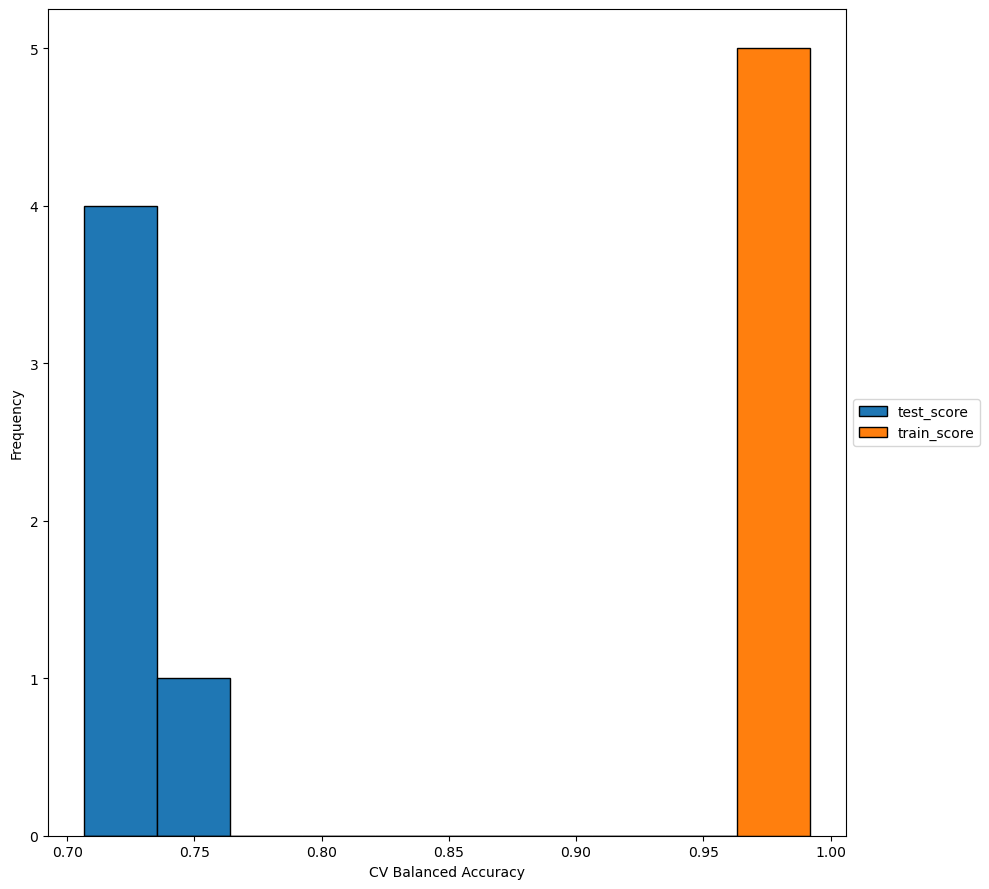

In [144]:
cv_results[['test_score', 'train_score']].plot.hist(edgecolor = 'black', figsize = (10,9))
plt.xlabel('CV Balanced Accuracy')
plt.legend(loc = 'center left', bbox_to_anchor = (1,0.5))
plt.tight_layout()

In [172]:
from sklearn.model_selection import validation_curve
rf = RandomForestClassifier(max_samples = 0.66, random_state = 42)
n_estimators = [1,5, 10, 25, 50, 75, 100, 150]
train_scores, test_scores = validation_curve(
    rf, X_train, y_train, param_name="n_estimators", param_range=n_estimators,
    cv=cv, scoring=scorer, n_jobs=2)

/home/grace/anaconda3/envs/py39/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Text(0, 0.5, 'Balanced Accuracy (mean)')

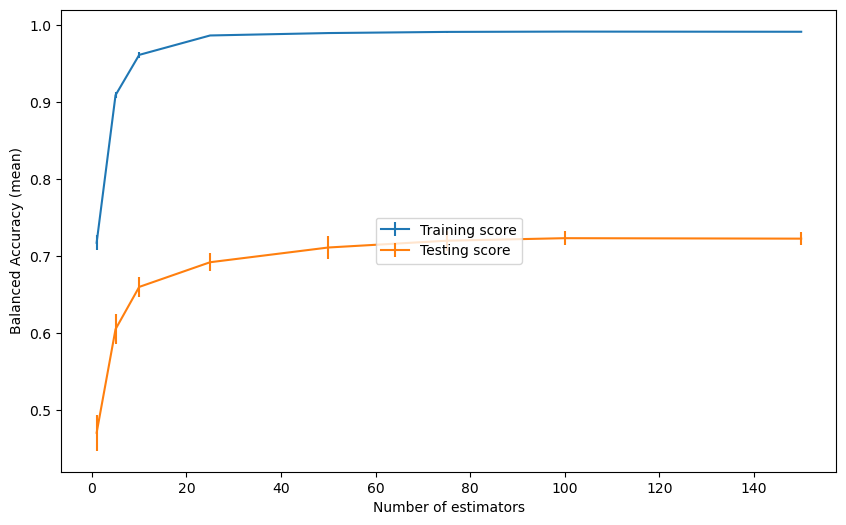

In [173]:
plt.figure(figsize = (10,6))
plt.errorbar(n_estimators, train_scores.mean(axis=1),
             yerr=train_scores.std(axis=1), label='Training score')
plt.errorbar(n_estimators, test_scores.mean(axis=1),
             yerr=test_scores.std(axis=1), label='Testing score')
plt.legend(loc = 'center')

plt.xlabel("Number of estimators")
plt.ylabel("Balanced Accuracy (mean)")

In [197]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [198]:
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_features': ['sqrt', 'log2', 'auto'],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', None]
}

In [199]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [200]:
rf_classifier = RandomForestClassifier(random_state = 42, max_samples = 0.66)

In [201]:
random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_grid, n_iter=50,
                                   scoring=make_scorer(balanced_accuracy_score), n_jobs=-1, cv=cv, random_state=42)

# Fit the random search to your data
random_search.fit(X_train, y_train)  # X: features, y: target variable

# Get the best parameters and best estimator
best_params = random_search.best_params_
best_estimator = random_search.best_estimator_

/home/grace/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/grace/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/grace/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove 

In [217]:
best_params

{'n_estimators': 300,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'class_weight': 'balanced'}

In [230]:
model = RandomForestClassifier(random_state = 42, max_samples = 0.66,n_estimators= 300,
 min_samples_split= 10,
 min_samples_leaf= 1,
 max_features='sqrt',
 max_depth= None,
 class_weight= 'balanced')

In [234]:
cv_results = cross_validate(model, X_train, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring = make_scorer(balanced_accuracy_score), return_estimator=True, n_jobs=-1,return_train_score = True)

In [237]:
cv_results['test_score'].mean()

0.7546502455459634

In [238]:
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_samples=0.66,
                       min_samples_split=10, n_estimators=300, random_state=42)

In [239]:
preds = model.predict(X_test)

In [240]:
balanced_accuracy_score(y_test, preds)

0.771244024096653

In [377]:
from sklearn.metrics import recall_score, accuracy_score
unique_classes = set(y_test)

# Initialize a dictionary to store the balanced accuracy scores for each class
balanced_accuracy_scores = {}
recall_scores = {}
# Compute balanced accuracy for each class
for cls in unique_classes:
    # Create binary labels for the current class
    y_true_cls = [1 if y == cls else 0 for y in y_test]
    y_pred_cls = [1 if y == cls else 0 for y in preds]
    
    # Compute recall (sensitivity) for the current class
    recall = recall_score(y_true_cls, y_pred_cls)
    
    # Compute specificity (true negative rate) for the current class
    tn = sum(1 for true, pred in zip(y_true_cls, y_pred_cls) if true == pred == 0)
    fp = sum(1 for true, pred in zip(y_true_cls, y_pred_cls) if true == 0 and pred == 1)
    specificity = tn / (tn + fp)
    
    # Compute balanced accuracy for the current class
    balanced_accuracy = (recall + specificity) / 2
    
    # Store the balanced accuracy score for the current class
    balanced_accuracy_scores[cls] = balanced_accuracy
    recall_scores [cls] = recall


In [381]:
recall_scores['Category1']

0.9316239316239316

In [242]:
from sklearn.metrics import auc, matthews_corrcoef
from sklearn.metrics import confusion_matrix, classification_report


In [243]:
matthews_corrcoef(y_test, preds)

0.821501200965755

In [244]:
confusion_matrix(y_test, preds)

array([[109,   1,   0, ...,   0,   0,   0],
       [  0,  33,   0, ...,   0,   0,   0],
       [  0,   0,   5, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,  33,   0,   0],
       [  1,   0,   0, ...,   0,   3,   0],
       [  0,   0,   0, ...,   0,   0,   2]])

In [353]:
report = (classification_report(y_test, preds))

/home/grace/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/grace/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/grace/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [305]:
report = report.split('\n')

In [306]:
test = pd.DataFrame(report)

In [307]:
test

,0
0,precision recall f1-score ...
1,
2,Category1 0.89 0.93 0.91 ...
3,Category10 0.82 0.82 0.82 ...
4,Category100 0.71 0.42 0.53 ...
...,...
120,
121,accuracy 0.83 ...
122,macro avg 0.76 0.77 0.74 ...
123,weighted avg 0.84 0.83 0.82 ...


In [337]:
result_df = test[0].str.split(expand=True)

In [338]:
 result_df.iloc[0,:].tolist()

['precision', 'recall', 'f1-score', 'support', None, None]

In [339]:
result_df.columns = ['Category', 'precision', 'recall', 'f1-score', 'support', 'untitled']

In [345]:
result_df = result_df.iloc[2:,:]

In [347]:
result_df.to_csv(external_dir+'cr.csv')

In [349]:
report_df = pd.read_csv(external_dir+'cr.csv')

In [366]:
report_df

,Category,precision,recall,f1-score,support
0,Category1,0.89,0.93,0.91,117
1,Category10,0.82,0.82,0.82,40
2,Category100,0.71,0.42,0.53,12
3,Category101,0.57,0.40,0.47,20
4,Category102,1.00,1.00,1.00,2
...,...,...,...,...,...
116,Category98,0.38,0.60,0.46,5
117,Category99,0.67,1.00,0.80,2
118,accuracy,NaN,NaN,0.76,3105
119,macro avg,0.76,0.77,0.74,3105


In [369]:
reverse_dict = {v:k for k,v in my_dict.items()}

In [370]:
report_df['terminal_category'] = report_df['Category'].replace(reverse_dict)

In [410]:
report_df.sort_values(by = 'BA', ascending = False).head(10)

,Category,precision,recall,f1-score,support,terminal_category,BA
91,Category75,1.00,1.0,1.0,14,"('Polyfluoroalkyl acids', 'lt7', 1.0, nan)",1.000000
24,Category14,1.00,1.0,1.0,11,"('HFCs', 'lt7', 2.0, nan)",1.000000
107,Category9,1.00,1.0,1.0,12,"('Aromatic PFASs', 'lt7', 4.0, 1.0)",1.000000
4,Category102,1.00,1.0,1.0,2,"('others, cyclic', 'lt7', 2.0, 1.0)",1.000000
75,Category60,1.00,1.0,1.0,3,"('PFAAs, cyclic', 'lt7', 2.0, nan)",1.000000
6,Category104,1.00,1.0,1.0,2,"('others, cyclic', 'lt7', 2.0, 3.0)",1.000000
101,Category84,1.00,1.0,1.0,4,"('Polyfluoroalkyl acids, cyclic', 'lt7', 5.0, ...",1.000000
117,Category99,0.67,1.0,0.8,2,"('others, cyclic', 'lt7', 1.0, 1.0)",0.999839
99,Category82,0.67,1.0,0.8,2,"('Polyfluoroalkyl acids, cyclic', 'lt7', 4.0, ...",0.999839
98,Category81,0.67,1.0,0.8,2,"('Polyfluoroalkyl acids, cyclic', 'lt7', 3.0, ...",0.999839


In [411]:
report_df.to_csv(external_dir+'classification_performance_140524.csv')

In [389]:
report_df =  pd.merge(report_df, pd.DataFrame(list(balanced_accuracy_scores.items()), columns = ['Category', 'BA']), on = 'Category', how = 'left' )

In [390]:
report_df

,Category,precision,recall,f1-score,support,terminal_category,BA
0,Category1,0.89,0.93,0.91,117,"('Aromatic PFASs', 'gte7', nan, nan)",0.963637
1,Category10,0.82,0.82,0.82,40,"('Aromatic PFASs', 'lt7', 4.0, 2.0)",0.911358
2,Category100,0.71,0.42,0.53,12,"('others, cyclic', 'lt7', 1.0, 2.0)",0.708010
3,Category101,0.57,0.40,0.47,20,"('others, cyclic', 'lt7', 1.0, 3.0)",0.699028
4,Category102,1.00,1.00,1.00,2,"('others, cyclic', 'lt7', 2.0, 1.0)",1.000000
...,...,...,...,...,...,...,...
116,Category98,0.38,0.60,0.46,5,"('others, cyclic', 'gte7', nan, nan)",0.799194
117,Category99,0.67,1.00,0.80,2,"('others, cyclic', 'lt7', 1.0, 1.0)",0.999839
118,accuracy,NaN,NaN,0.76,3105,accuracy,NaN
119,macro avg,0.76,0.77,0.74,3105,macro avg,NaN


In [421]:
report_df1 = report_df.iloc[:118,:].melt(id_vars=['terminal_category'], value_vars=['recall','BA'], var_name='metric', value_name='value')

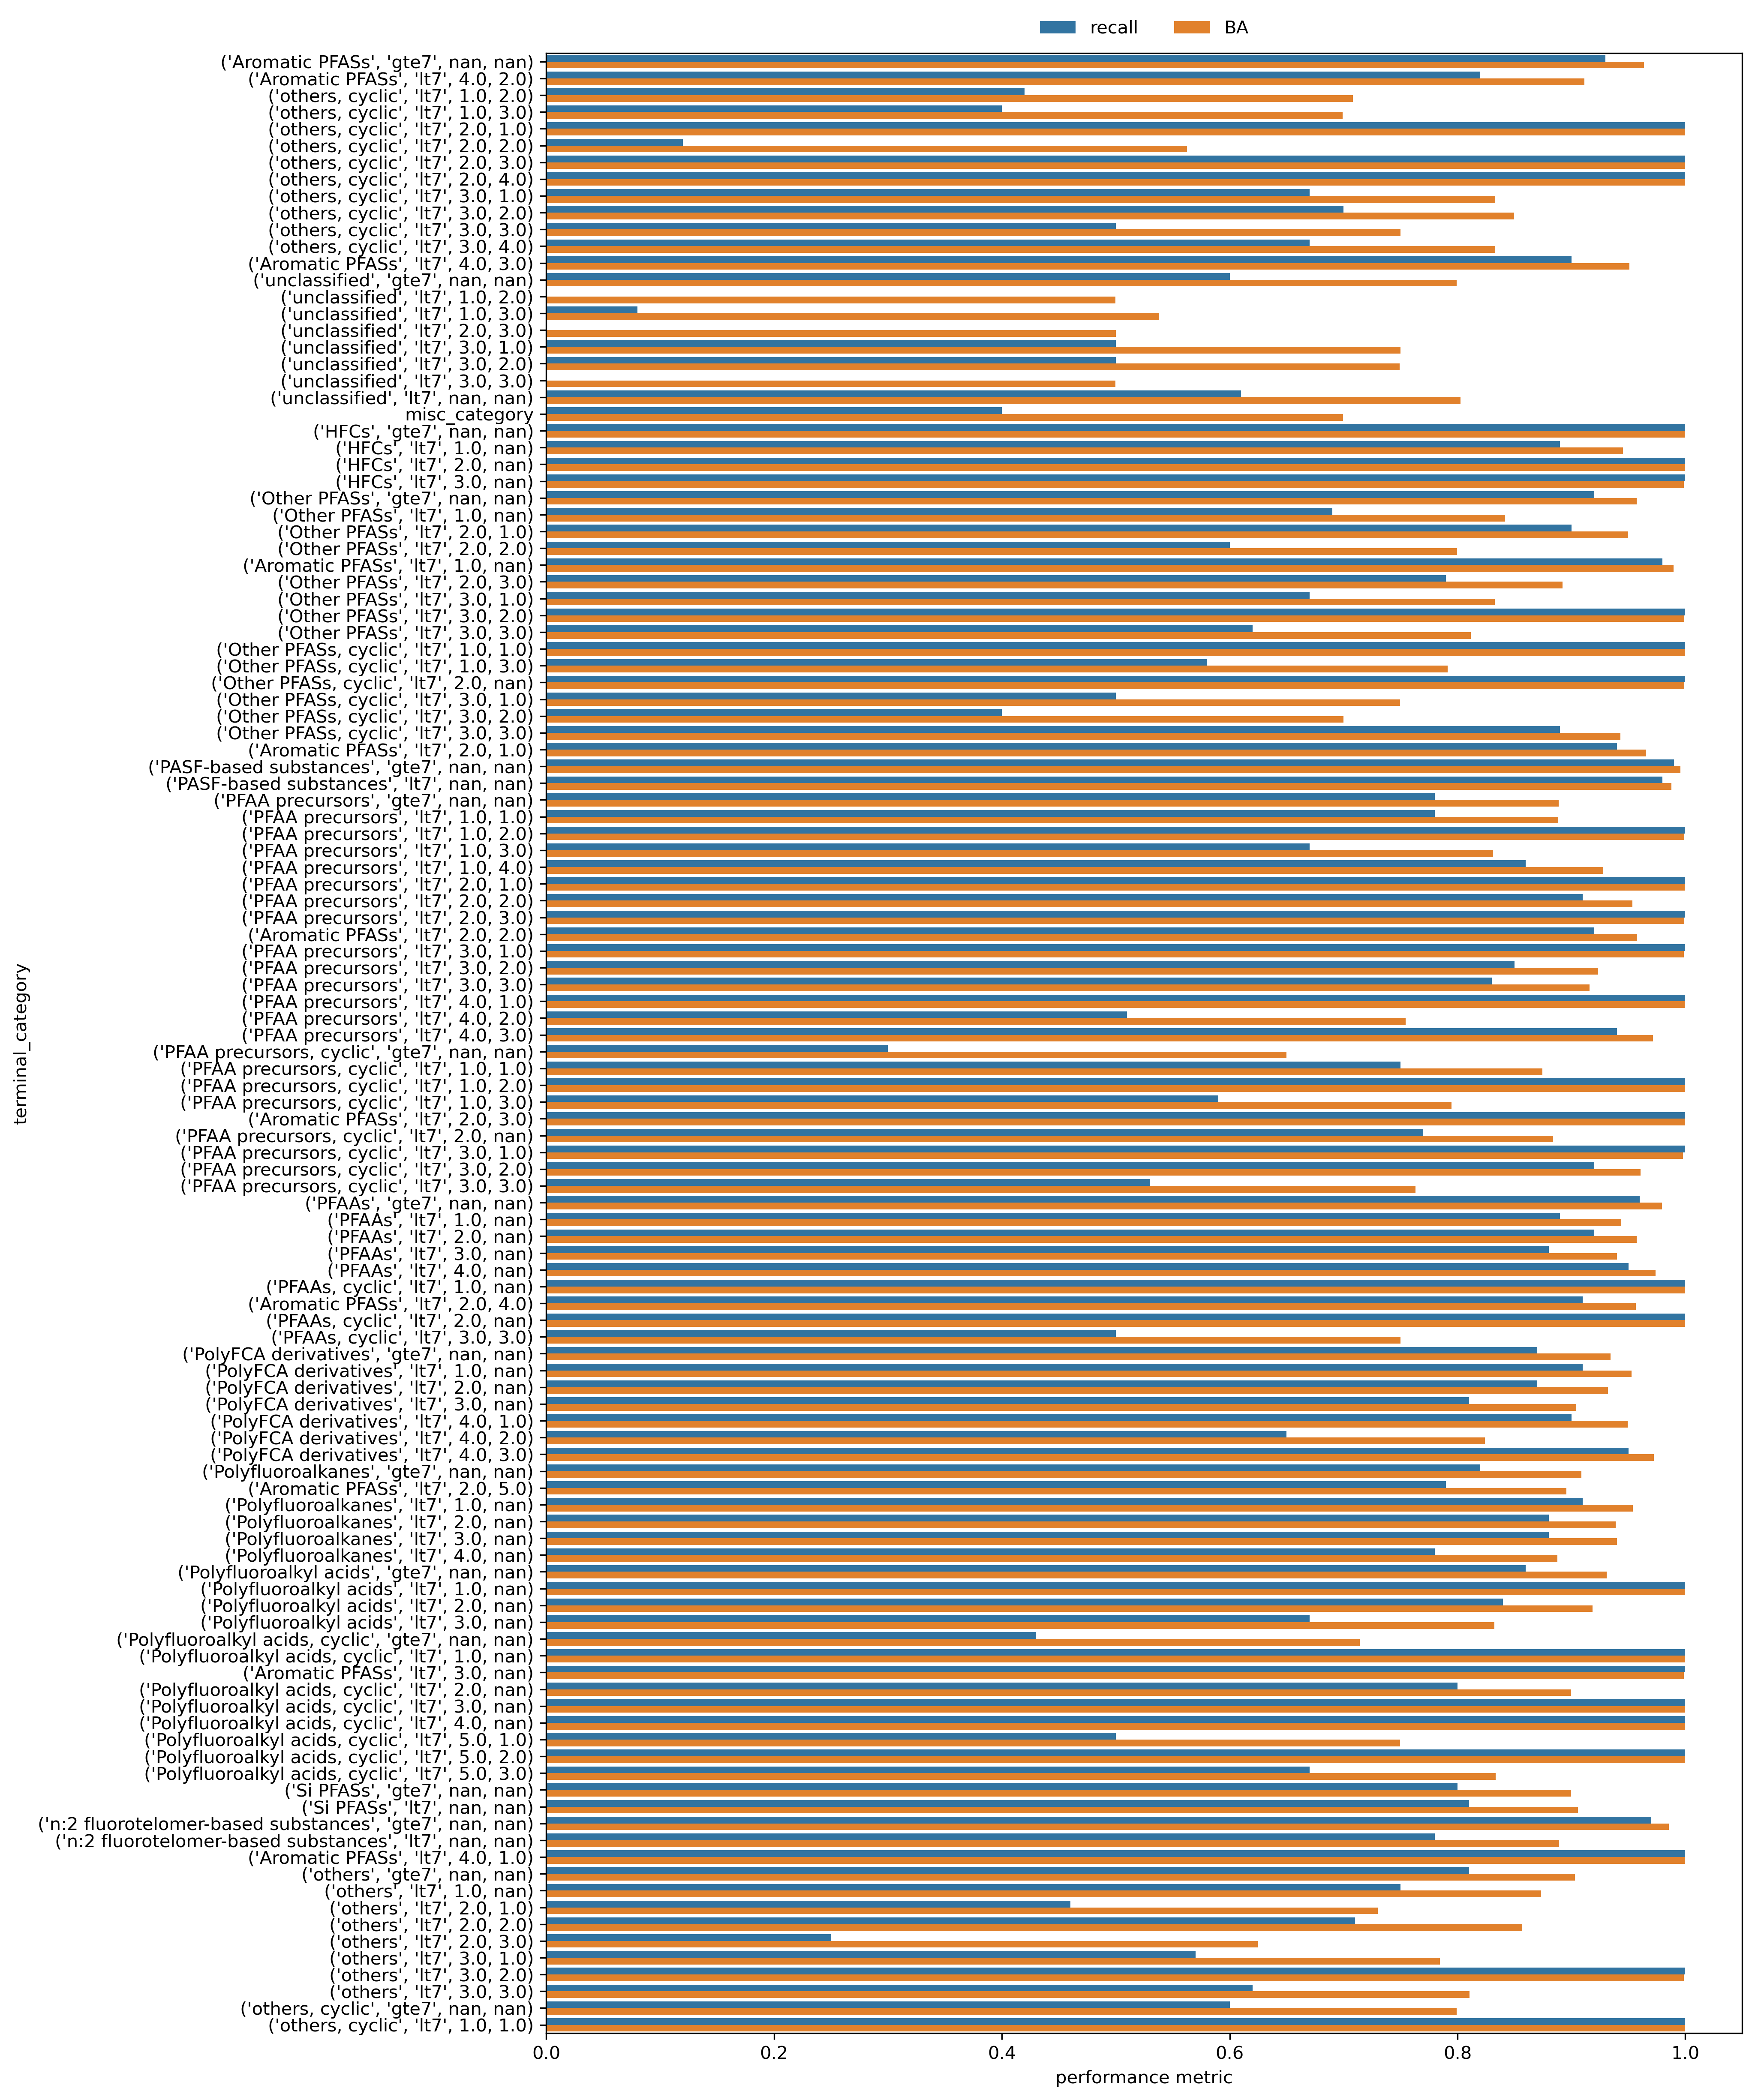

In [427]:
fig,ax = plt.subplots(figsize=(12, 20), dpi=300)
p = sns.barplot(ax=ax, data=report_df1, y='terminal_category', x='value', hue='metric', orient='h')
sns.move_legend(ax, "lower center",bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False, fontsize=10 )
ax.set_xlabel('performance metric')
fig.savefig(figures_dir+'classification_rfc.png')